In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ecommerce-data/data.csv


### Table of contents - 
* [Introduction to RFM Customer Segmentation](#Intro)
* [EDA 🔨](#wrangle)
* [Recency ⏳](#recency)
* [Frequency⏱ ](#frequency)
* [Monetary value 💰](#monetary)
* [Deep dive 🏊‍](#deep-dive)
* [Outlier detection and capping using IQR 🧢](#outlier)
* [Feature Scaling - Standardization⚖️](#scaling)
* [Elbow Method](#elbow)
* [Building,Predicting,Accuracy - KMeans](#model)
* [Visualising the clusters](#cluster)

### Introduction to RFM Customer segmentation <a class="anchor"  id="Intro"></a>

RFM is a common business analysis tool that is often used to segment the customers based on Recency (How recent was the customer's purchase?) , Frequency (How frequently does the customer purchase from us?) and Monetary value (How much money does the customer spend?)

Through the RFM attributes, we can distingush customers displaying similar purchase trends and group them into one cluster. Later, the company can use different marketing/promotions to target these clusters based on the customer's purchasing pattern and behaviour. 

For example, if there is a segment of customers that have a high frequency of purchase with us, we could offer them loyalty points. We could also send nudges of our sales/offers to our thrifty customer segment that prefer shopping during sales. 

### EDA <a class="anchor"  id="wrangle"></a>

In [2]:
df = pd.read_csv('/kaggle/input/ecommerce-data/data.csv',encoding='unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
# Dropping the rows that have unit price and Quantity as negative. 
df = df[(df['UnitPrice']> 0) & (df['Quantity']>0)]

In [4]:
#Change data type of InvoiceDate to DateTime
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])

In [5]:
#Dropping the duplicate rows
df = df.drop_duplicates()

In [6]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,524878.000000,524878,524878.000000,392692.000000
mean,10.616600,2011-07-04 15:30:16.317049088,3.922573,15287.843865
min,1.000000,2010-12-01 08:26:00,0.001000,12346.000000
25%,1.000000,2011-03-28 12:13:00,1.250000,13955.000000
50%,4.000000,2011-07-20 11:22:00,2.080000,15150.000000
75%,11.000000,2011-10-19 11:41:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,13541.330000,18287.000000
std,156.280031,NaN,36.093028,1713.539549


### Recency <a class="anchor"  id="recency"></a>

While conducting an analysis on our customer base we would be interested in understanding how recent a customer's purchase with us was and this attribute is termed as Recency. It is usually calculated based on a reference date.

In [7]:
#Let us set the reference date as the most recent purchase date
most_recent_purchase = max(df['InvoiceDate'])
most_recent_purchase

Timestamp('2011-12-09 12:50:00')

In [8]:
#Calculating Recency for each purchase
df['Recency'] = df['InvoiceDate'].apply(lambda row: (most_recent_purchase - row).days)

Since a customer might have multiple purchases, we will now associate each customer with a single recency based on their most recent purchase and also visualise the distribution.

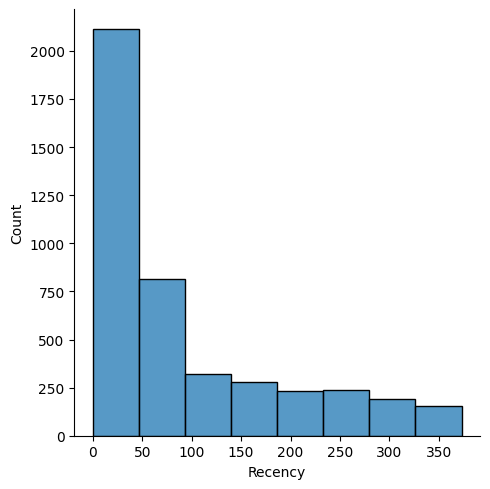

In [9]:
df_recent = df.groupby('CustomerID')['Recency'].min()
sns.displot(df_recent,bins=8)

Based on the distribution it looks like a good number of our customers have recently made a purchase with us. More than 2000 customers have made a purchase in the last 1.5 ish months from the reference date.

### Frequency <a class="anchor"  id="frequency"></a>

Another key attribute is how frequently a customer is purchasing from us. This is addressed using Frequency.

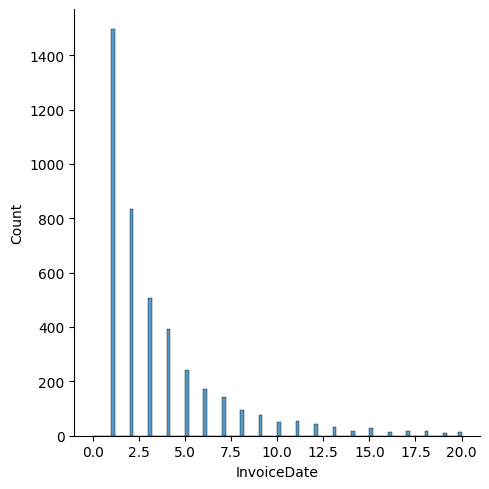

In [10]:
df_freq = df.groupby('CustomerID')['InvoiceDate'].nunique()
sns.displot(df_freq,bins=100,binrange=(0,20))

In [11]:
df_freq.value_counts()

InvoiceDate
1      1495
2       833
3       508
4       391
5       242
6       172
7       142
8        94
9        77
11       53
10       51
12       42
13       31
15       29
17       18
18       17
14       16
20       13
16       12
21       10
19       10
26        7
30        7
25        6
22        6
24        5
27        4
23        4
36        3
33        2
46        2
29        2
55        2
34        2
39        2
44        2
31        2
50        2
28        2
32        2
57        1
91        1
124       1
210       1
38        1
83        1
61        1
93        1
35        1
41        1
47        1
58        1
201       1
73        1
95        1
37        1
54        1
45        1
Name: count, dtype: int64

### Monetary <a class="anchor"  id="monetary"></a>

The last attribute of an RFM analysis is the monetary ie. what does the total purchase made by a customer amount to. This can be calculated using the unit price of an item and the quantity of the items bought.

In [12]:
#Adding a new column for amount
df['Amount'] = df['UnitPrice']*df['Quantity']

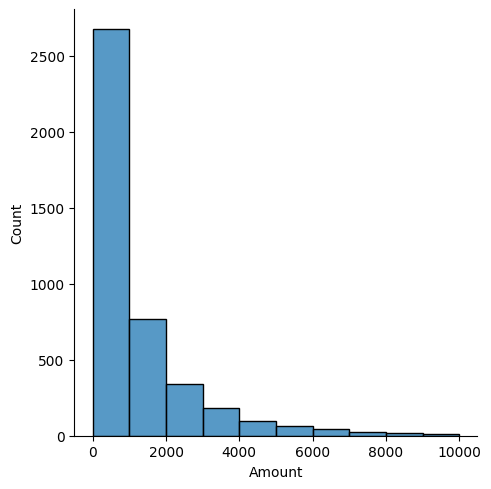

In [13]:
df_monetary = df.groupby('CustomerID')['Amount'].sum()
sns.displot(df_monetary,bins=10,binrange=(0,10000))

In [14]:
df_monetary.value_counts()

Amount
76.32      4
35.40      3
363.65     3
15.00      3
440.00     3
          ..
477.79     1
1530.75    1
605.06     1
183.85     1
1837.28    1
Name: count, Length: 4256, dtype: int64

### Deep dive  <a class="anchor"  id="deep-dive"></a>

In [15]:
#Creating a new data frame having Customer ID and RFM values.
rfm_df = pd.DataFrame(columns=['CustomerID'])

In [16]:
rfm_df['CustomerID'] = df_recent.index
rfm_df = rfm_df.merge(df_recent,on='CustomerID')

In [17]:
rfm_df = rfm_df.merge(df_freq,on='CustomerID')

In [18]:
rfm_df = rfm_df.merge(df_monetary,on='CustomerID')

In [19]:
rfm_df.rename(columns={'InvoiceDate':'Frequency'},inplace=True)

In [20]:
rfm_df

,CustomerID,Recency,Frequency,Amount
0,12346.0,325,1,77183.60
1,12347.0,1,7,4310.00
2,12348.0,74,4,1797.24
3,12349.0,18,1,1757.55
4,12350.0,309,1,334.40
...,...,...,...,...
4333,18280.0,277,1,180.60
4334,18281.0,180,1,80.82
4335,18282.0,7,2,178.05
4336,18283.0,3,16,2045.53


In [21]:
rfm_df.describe()

,CustomerID,Recency,Frequency,Amount
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,91.536422,4.250807,2048.688081
std,1721.808492,100.014169,7.635202,8985.230220
min,12346.000000,0.000000,1.000000,3.750000
25%,13813.250000,17.000000,1.000000,306.482500
50%,15299.500000,50.000000,2.000000,668.570000
75%,16778.750000,141.000000,5.000000,1660.597500
max,18287.000000,373.000000,210.000000,280206.020000


<Axes: xlabel='Recency', ylabel='Frequency'>

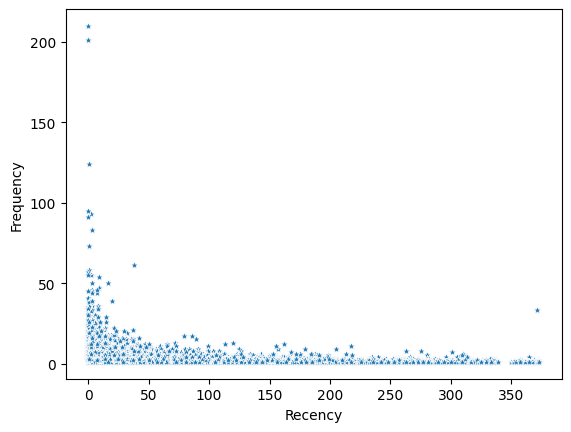

In [22]:
#Recency vs Frequency
sns.scatterplot(data=rfm_df, x="Recency", y="Frequency",marker='*')

It looks like the customers with high frequency often have a low recency, ie have made a recent purchase with us.

[(0.0, 10000.0)]

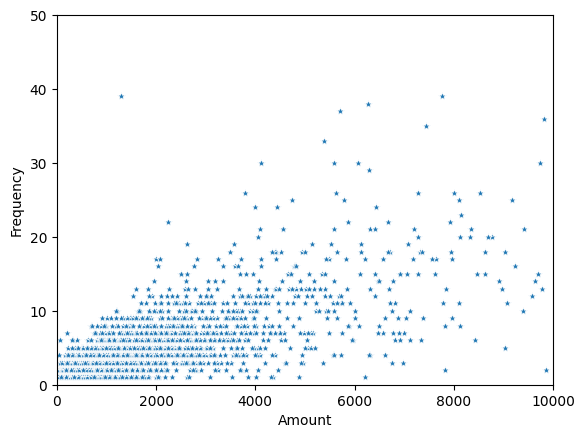

In [23]:
#Frequency vs Amount
ax = sns.scatterplot(data=rfm_df, x="Amount", y="Frequency",marker='*')
ax.set(ylim=(0,50))
ax.set(xlim=(0,10000))

Let us also analyse which month had the highest purchase numbers

In [24]:
df['Month'] = df['InvoiceDate'].dt.strftime('%m')

In [25]:
df.sort_values('Month',inplace=True)

<Axes: xlabel='Month'>

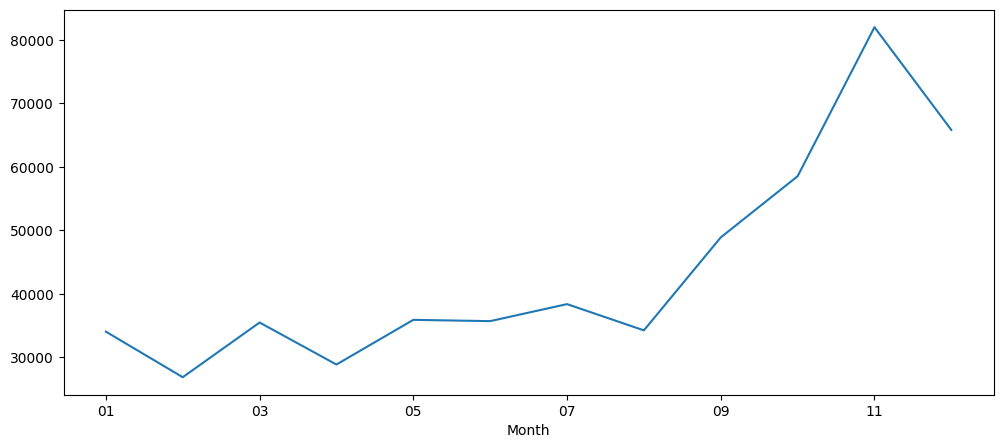

In [26]:
df['Month'].value_counts(sort=False).plot(figsize=(12,5))

Looks like November recorded a high number of sales, maybe this was the time when the black friday sale was annouced or there was an increase in the number of customers visiting the store due to successful promotions.

### Outlier detection and capping using IQR <a class="anchor"  id="outlier"></a>

Recency: 


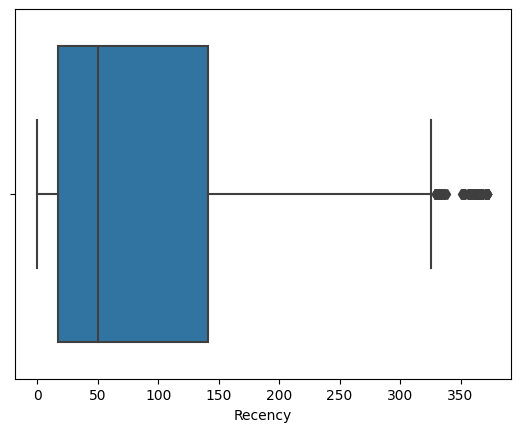

Frequency: 


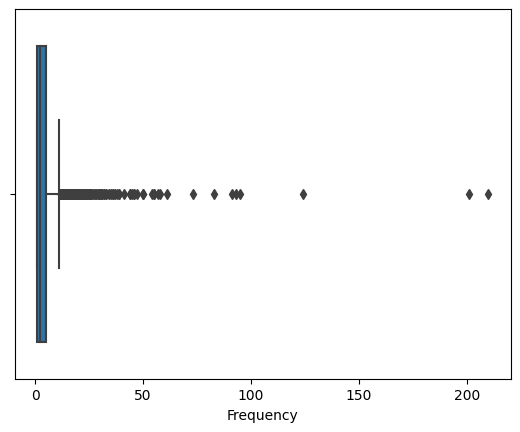

Amount: 


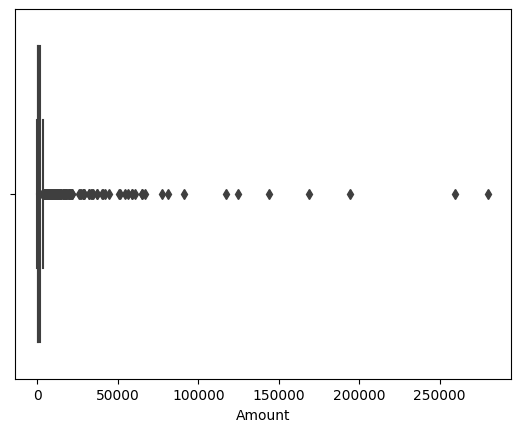

In [27]:
#outlier visualization
list1 = ['Recency','Frequency','Amount']
for i in list1:
    print(str(i)+': ')
    ax = sns.boxplot(x=rfm_df[str(i)])
    plt.show()

Our data has a good amount of outliers as seen in the boxplots above. It is essential to treat these outliers as we will be making use of the K-Means algorithm for clustering and this algorithm, being a distance-based algorithm, can highly be affected by the presence of outliers.

I will be capping the outliers using the IQR method.

In [28]:
rfm_df.drop('CustomerID',axis=1,inplace=True)

In [29]:
rfm_df

,Recency,Frequency,Amount
0,325,1,77183.60
1,1,7,4310.00
2,74,4,1797.24
3,18,1,1757.55
4,309,1,334.40
...,...,...,...
4333,277,1,180.60
4334,180,1,80.82
4335,7,2,178.05
4336,3,16,2045.53


In [30]:
def removeOutliers(data, col):
    Q3 = np.quantile(data[col], 0.75)
    Q1 = np.quantile(data[col], 0.25)
    IQR = Q3 - Q1
    copy = data.copy()
    print("IQR value for column %s is: %s" % (col, IQR))
 
    lower_range = Q1 - 1.5 * IQR
    upper_range = Q3 + 1.5 * IQR
    print(lower_range,upper_range)
    #np.where(condition, true, false)
    copy[col] = np.where(
    copy[col] > upper_range,
    upper_range,
    np.where(
        copy[col] < lower_range,
        lower_range,
        copy[col]
        )
    )

    return copy

In [31]:
final_recency = removeOutliers(rfm_df,'Recency')
final_frequency = removeOutliers(final_recency,'Frequency')
final_rfm_df = removeOutliers(final_frequency,'Amount')

IQR value for column Recency is: 124.0
-169.0 327.0
IQR value for column Frequency is: 4.0
-5.0 11.0
IQR value for column Amount is: 1354.1149999999998
-1724.6899999999996 3691.7699999999995


In [32]:
final_rfm_df.describe()

,Recency,Frequency,Amount
count,4338.000000,4338.000000,4338.000000
mean,90.447441,3.481558,1159.010762
std,97.199547,3.033858,1146.777473
min,0.000000,1.000000,3.750000
25%,17.000000,1.000000,306.482500
50%,50.000000,2.000000,668.570000
75%,141.000000,5.000000,1660.597500
max,327.000000,11.000000,3691.770000


Recency before and after outlier capping using IQR


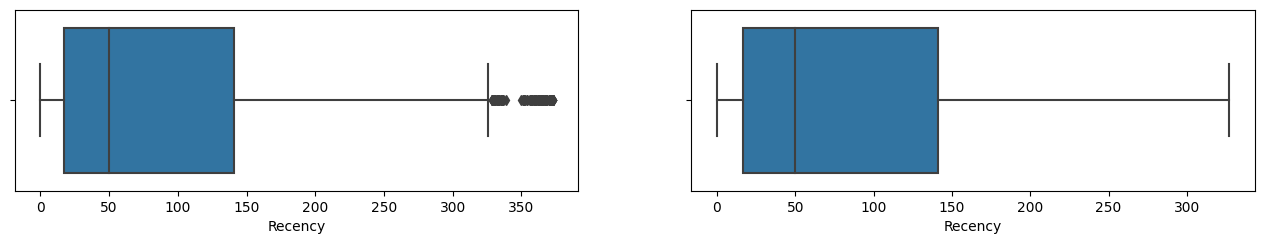

Frequency before and after outlier capping using IQR


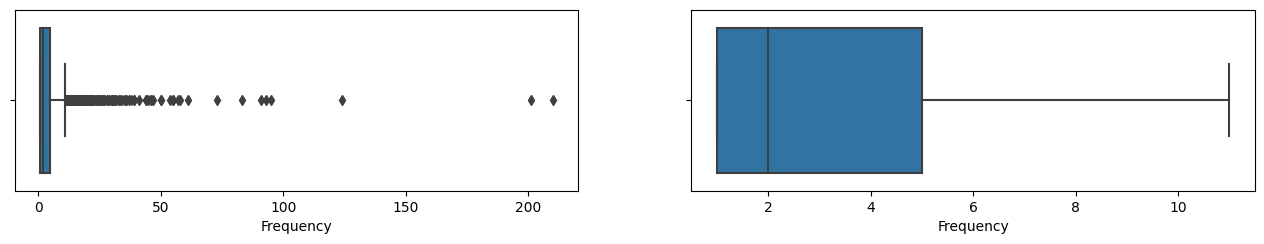

Amount before and after outlier capping using IQR


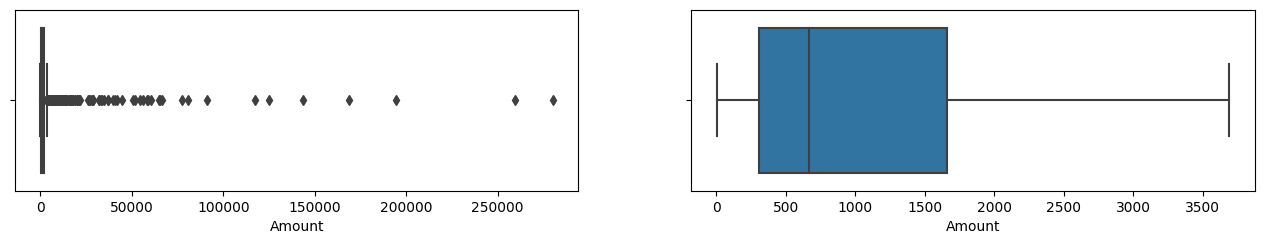

In [33]:
#Boxplots
i = 1 
for col in ['Recency','Frequency','Amount']:
    print(col+' before and after outlier capping using IQR')
    plt.figure(figsize=(16,8))
    plt.subplot(3,2,i)
    sns.boxplot(x=rfm_df[col])
    plt.subplot(3,2,i+1)
    sns.boxplot(x=final_rfm_df[col])
    ++i
    #plt.set_title(col)
    plt.show()

As we can see, we have treated the outliers by capping using the IQR method. 

### Feature Scaling - Standardization <a class="anchor"  id="scaling"></a>

We can see that our three RFM attributes have very different ranges. To ensure that the model does not assign a higher weightage to a feature having higher magnitude, it is essential to scale these features and convert them to a standard normal distribution, ie a normal distribution having mean close to zero and variance close to 1.

In [34]:
#Feature scaling
from sklearn.preprocessing import StandardScaler

cols = final_rfm_df.columns

scaler = StandardScaler()

rfm = scaler.fit_transform(final_rfm_df)

rfm_scaled = pd.DataFrame(rfm, columns=[cols])

In [35]:
rfm_scaled.describe()

,Recency,Frequency,Amount
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,7.043185e-17,9.008725e-18,-1.703468e-16
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-9.306408e-01,-8.180490e-01,-1.007514e+00
25%,-7.557227e-01,-8.180490e-01,-7.434978e-01
50%,-4.161758e-01,-4.883976e-01,-4.277179e-01
75%,5.201504e-01,5.005563e-01,4.374385e-01
max,2.433960e+00,2.478464e+00,2.208843e+00


### Elbow Method to determine number of clusters <a class="anchor"  id="elbow"></a>

We will be making use of the elbow method to determine the number of clusters.

Text(0, 0.5, 'Inertia')

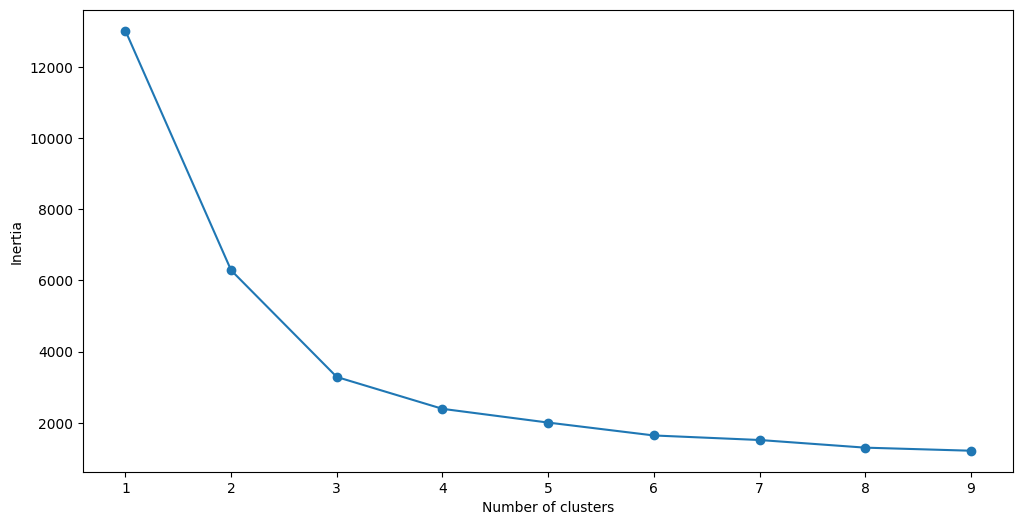

In [36]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
SSE = []
for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++',n_init="auto")
    kmeans.fit(rfm_scaled)
    SSE.append(kmeans.inertia_)
# converting the results into a dataframe and plotting them
frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Point of inflection of the curve us on the 3 cluster mark, therefore let us set the number of clusters to 3.

### Building,Predicting and Accuracy - KMeans Model <a class="anchor"  id="model"></a>

In [37]:
# First, build a model with 3 clusters
kmeans = KMeans( n_clusters = 3, init='k-means++',n_init="auto")
kmeans.fit(rfm_scaled)

KMeans(n_clusters=3, n_init='auto')

In [38]:
#Checking the accuracy using the silhouette score
print(silhouette_score(rfm_scaled, kmeans.labels_, metric='euclidean'))

0.5092869612125239


In [39]:
#Clustering
pred = kmeans.predict(rfm_scaled)
rfm_cluster = final_rfm_df.copy()
rfm_cluster['cluster'] = pred

In [40]:
rfm_cluster

,Recency,Frequency,Amount,cluster
0,325.0,1.0,3691.77,2
1,1.0,7.0,3691.77,0
2,74.0,4.0,1797.24,1
3,18.0,1.0,1757.55,1
4,309.0,1.0,334.40,2
...,...,...,...,...
4333,277.0,1.0,180.60,2
4334,180.0,1.0,80.82,2
4335,7.0,2.0,178.05,1
4336,3.0,11.0,2045.53,0


### Visulising the clusters <a class="anchor"  id="cluster"></a>

<Axes: xlabel='Recency', ylabel='Frequency'>

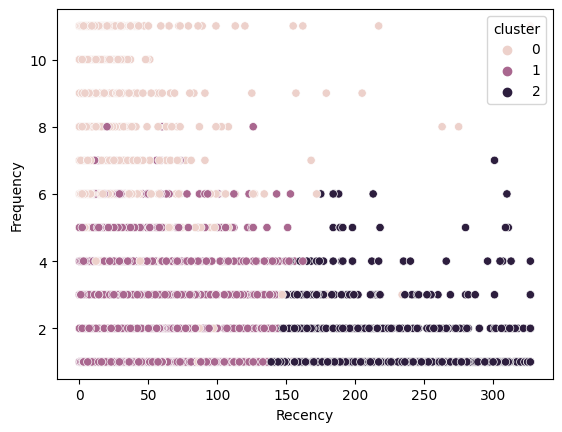

In [41]:
sns.scatterplot(data=rfm_cluster, x="Recency", y="Frequency",hue='cluster')

As revealed by the silhouette score and confirmed by the plot above, the clusters are not very clearly separated.

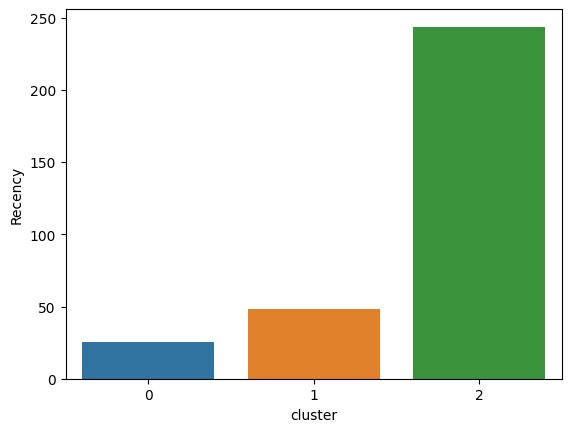

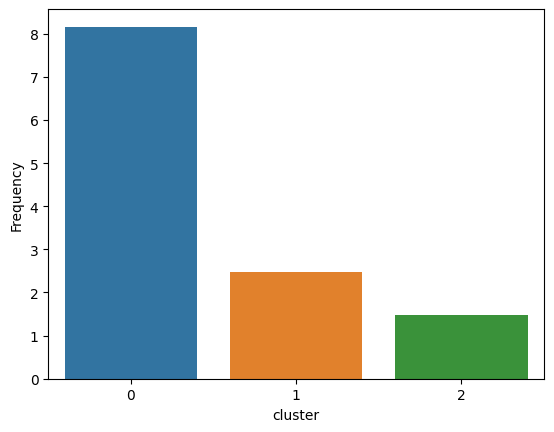

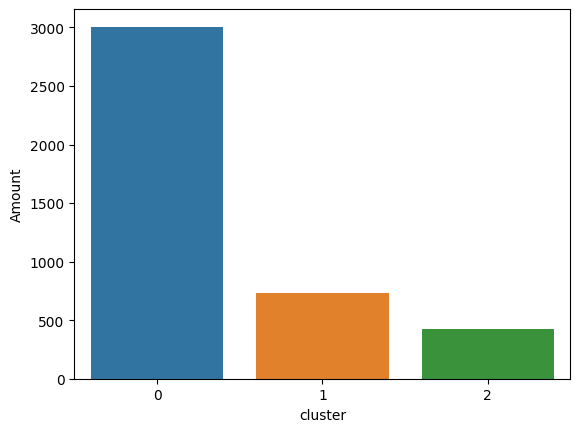

In [42]:
avg_df = rfm_cluster.groupby(['cluster'], as_index=False).mean()
for i in list1:
    sns.barplot(x='cluster',y=str(i),data=avg_df)
    plt.show()

So based on the clustering it is evident that on the average, the customers belonging to cluster 2 have a good recency (have purchased with us in the last one month), great frequency and spend. Based on these details, we might want to target the loyalty points to these customers and provide them with early access to any kind of sales. 

Further we could also look into the purchasing timeline of the customers in different clusters, analyse what kind of products they like - decorative, stationary, food, decode what unitPrice of a product is more attractive to boost it's sales among different segments.  

Thank you for reading!